# Fast-reversion Heston FX demo

### 1. Surface generation using FT

In [109]:
import numpy as np
from frh_fx import mpl, nig, frh, uts, sim, blk
from matplotlib import pyplot as plt
% matplotlib inline

In [110]:
mpl.config(scale=1.5,print_keys=False)

First let us look at an FRH triangle of implied volatility surface.

Set maturities

In [111]:
T = np.array([1/52,1])

Set model parameters

In [112]:
σ1,ρ1 = 0.10, 0.2
σ2,ρ2 = 0.10,-0.5
γ = 1
ρ = 0.5

Translate to NIG parameters

In [113]:
α1,β1,δ1,μ1 = frh.nig_params(σ1,ρ1,γ)
α2,β2,δ2,μ2 = frh.nig_params(σ2,ρ2,γ)

Obtain cross NIG parameters

In [114]:
θ1 = α1,β1,δ1
θ2 = α2,β2,δ2
α3,β3,δ3,μ3 = nig.cross_params(θ1,θ2,ρ)
θ3 = α3,β3,δ3

Set some sensible log-strikes for a surface

In [115]:
k = uts.get_logstrikes(T)

Compute prices, then volatilities, on this surface

In [116]:
p1 = nig.price(k,T,θ1)
p2 = nig.price(k,T,θ2)
p3 = nig.price(k,T,θ3)

In [117]:
BS1a = blk.surface(k,T,p1)
BS2a = blk.surface(k,T,p2)
BS3a = blk.surface(k,T,p3)

Now plot

Saved at: /Users/ryanmccrickerd/gdrive/rypy/frh-fx/plots
Saved at: /Users/ryanmccrickerd/gdrive/rypy/frh-fx/plots


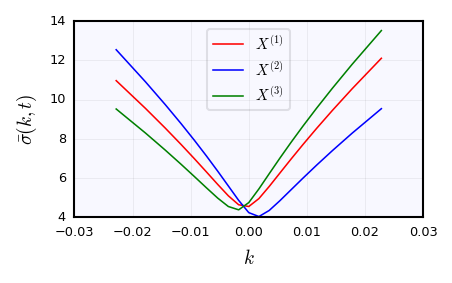

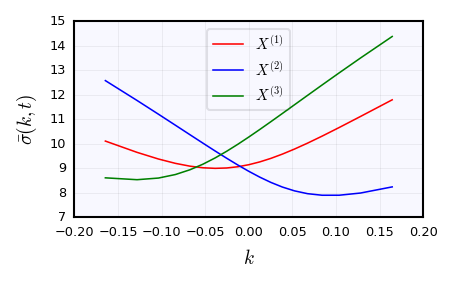

In [118]:
for i in range(len(k[:,0])):
    plot,axes = plt.subplots()
    axes.plot(k[i,:],100*BS1a[i,:],'r')
    axes.plot(k[i,:],100*BS2a[i,:],'b')
    axes.plot(k[i,:],100*BS3a[i,:],'g')
    axes.legend([r'$X^{(1)}$',
                 r'$X^{(2)}$',
                 r'$X^{(3)}$'])
    axes.set_xlabel(r'$k$')
    axes.set_ylabel(r'$\bar{\sigma}(k,t)$')
    uts.save_plot()

In [119]:
uts.save_data(k,T,BS3a)

Saved at: /Users/ryanmccrickerd/gdrive/rypy/frh-fx/data/20180521-072852


### 2. Verification using MC

Now we should check we do obtain these surfaces using a Monte Carlo simulation.

In [120]:
T = T[0]
m,n = 2**17,2**0
t = np.linspace(0,T,n+1)
Δ = T/n

In [121]:
np.random.seed(0)
ɛ1,ɛ2 = sim.correlated_noise(ρ,size=(m,n))

In [122]:
v = sim.subordinator(T,γ,size=(m,n))
v1 = sim.scaled_sub(v,σ1,ρ1)
v2 = sim.scaled_sub(v,σ2,ρ2)

In [123]:
X1 = sim.nig_process(v1,ɛ1,Δ,θ1)
X2 = sim.nig_process(v2,ɛ2,Δ,θ2)
X3 = X1/X2

In [124]:
T = np.array([T])
k = uts.get_logstrikes(T)

In [125]:
P1 = sim.prices(X1,k,T)
P2 = sim.prices(X2,k,T)
P3 = sim.prices(X3,k,T,N=X2)

In [126]:
BS1b = blk.surface(k,T,P1)
BS2b = blk.surface(k,T,P2)
BS3b = blk.surface(k,T,P3)

Now plot comparitive charts

Saved at: /Users/ryanmccrickerd/gdrive/rypy/frh-fx/plots


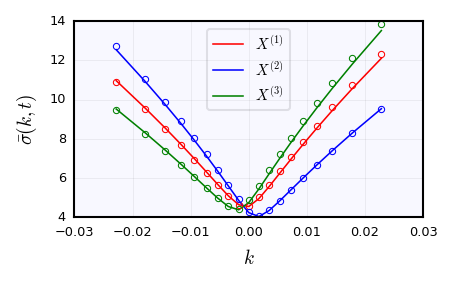

In [127]:
plot,axes = plt.subplots()
axes.plot(k[0,:],100*BS1a[0,:],'r')
axes.plot(k[0,:],100*BS2a[0,:],'b')
axes.plot(k[0,:],100*BS3a[0,:],'g')
axes.plot(k[0,:],100*BS1b[0,:],'ro')
axes.plot(k[0,:],100*BS2b[0,:],'bo')
axes.plot(k[0,:],100*BS3b[0,:],'go')
axes.legend([r'$X^{(1)}$',
             r'$X^{(2)}$',
             r'$X^{(3)}$'])
axes.set_xlabel(r'$k$')
axes.set_ylabel(r'$\bar{\sigma}(k,t)$');
uts.save_plot()

### Time-dependent params

Finally we demonstrate the time-dependent case, and another interesting symmetry.

In [136]:
# t = np.linspace(0,1,101)
def σ(t): return  0.1
def ρ(t): return -0.5
def γ(t): return t**0.5
θ = σ,ρ,γ

In [137]:
T = np.array([1/252,1/52,1/12,3/12,6/12,9/12,1])
k = uts.get_logstrikes(T)

In [138]:
k.shape

(7, 19)

In [139]:
p = frh.price(k,T,θ)

In [140]:
BS = blk.surface(k,T,p)

Saved at: /Users/ryanmccrickerd/gdrive/rypy/frh-fx/plots


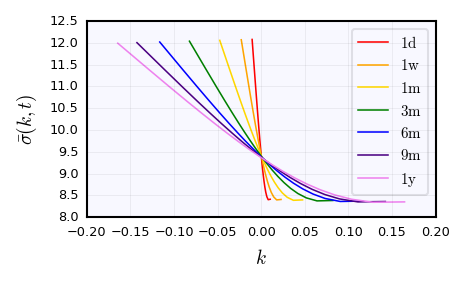

In [144]:
plot,axes = plt.subplots()
for i in range(7):
    axes.plot(k[i,:],100*BS[i,:])
axes.legend([r'$\mathrm{1d}$',
             r'$\mathrm{1w}$',
             r'$\mathrm{1m}$',
             r'$\mathrm{3m}$',
             r'$\mathrm{6m}$',
             r'$\mathrm{9m}$',
             r'$\mathrm{1y}$'])
axes.set_xlabel(r'$k$')
axes.set_ylabel(r'$\bar{\sigma}(k,t)$')
uts.save_plot()

In [142]:
Δ = uts.get_deltas(BS,k,T,ρ=ρ(0))

Saved at: /Users/ryanmccrickerd/gdrive/rypy/frh-fx/plots


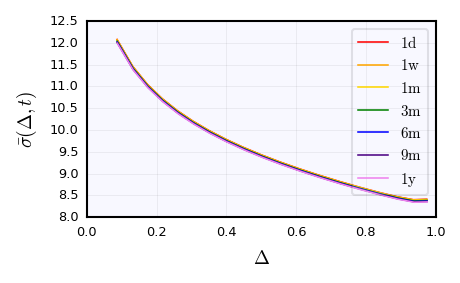

In [143]:
plot,axes = plt.subplots()
for i in range(7):
    axes.plot(Δ[i,:],100*BS[i,:])
axes.legend([r'$\mathrm{1d}$',
             r'$\mathrm{1w}$',
             r'$\mathrm{1m}$',
             r'$\mathrm{3m}$',
             r'$\mathrm{6m}$',
             r'$\mathrm{9m}$',
             r'$\mathrm{1y}$'])
axes.set_xlabel(r'$\Delta$')
axes.set_ylabel(r'$\bar{\sigma}(\Delta,t)$')
uts.save_plot()

Have you ever seen anything as amazing as that... ?!?

Now for my last trick.

In [27]:
from scipy.stats import beta

In [28]:
a = 0.925
y = 10*beta.pdf(Δ[1,:],a,a)

Saved at: /Users/ryanmccrickerd/gdrive/rypy/frh-fx/plots


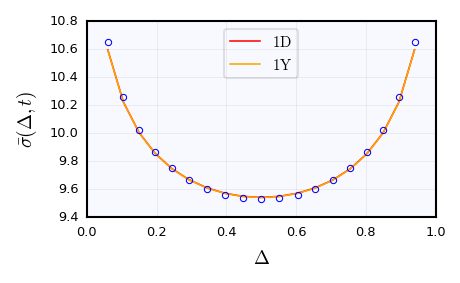

In [29]:
plot,axes = plt.subplots()
for i in range(2):
    axes.plot(Δ[i,:],100*BS[i,:])
axes.plot(Δ[1,:],y,'bo')
axes.legend([r'$\mathrm{1D}$',
             r'$\mathrm{1Y}$'])
axes.set_xlabel(r'$\Delta$')
axes.set_ylabel(r'$\bar{\sigma}(\Delta,t)$')
uts.save_plot()

Answers on a postcard...